In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

pd.set_option('display.max_rows', 50)
%matplotlib inline

## Load rating data

In [2]:
path = 'data/ml-10M100K/'  # ML-10M files
all_files = glob.glob(os.path.join(path, "ratings*.csv"))
ratings = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

### Get number of ratings per movie

In [3]:
rating_counts = ratings.groupby('movieId').agg({'rating':'count'}).reset_index()
rating_counts.columns = ['movieId', 'n_ratings']
rating_counts.head()

,movieId,n_ratings
0,0,2412
1,1,14975
2,2,17851
3,3,16075
4,4,18925


### Get average rating per movie

In [4]:
rating_avgs = ratings.groupby('movieId').agg({'rating':'mean'}).reset_index()
rating_avgs.columns = ['movieId', 'mean_rating']
rating_avgs.head()

,movieId,mean_rating
0,0,2.861318
1,1,3.125209
2,2,2.936950
3,3,3.418414
4,4,3.349353


### Join to movies file

In [5]:
movies = pd.read_csv(path+'movies.tsv', sep='\t')
movies = pd.merge(movies, rating_counts, how='inner', on='movieId')
movies = pd.merge(movies, rating_avgs, how='inner', on='movieId')

movies.head(10)

,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,n_ratings,mean_rating
0,0,Boomerang (1992),0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,2412,2.861318
1,1,"Net, The (1995)",1,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,14975,3.125209
2,2,Dumb & Dumber (1994),0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,17851,2.936950
3,3,Outbreak (1995),1,0,0,0,0,0,0,1,...,0,0,0,0,1,1,0,0,16075,3.418414
4,4,Stargate (1994),1,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,18925,3.349353
5,5,Star Trek: Generations (1994),1,1,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,16167,3.336271
6,6,"Flintstones, The (1994)",0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,5366,2.480153
7,7,Forrest Gump (1994),0,0,0,0,1,0,0,1,...,0,0,0,1,0,0,1,0,34457,4.013582
8,8,"Jungle Book, The (1994)",0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,4016,3.447709
9,9,"Lion King, The (1994)",0,1,1,1,0,0,0,1,...,0,1,0,0,0,0,0,0,20972,3.748593


# Embeddings dimensionality reduction
[Multiple distribution jointplot](https://stackoverflow.com/questions/35920885/how-to-overlay-a-seaborn-jointplot-with-a-marginal-distribution-histogram-fr)

In [6]:
emb = pd.read_csv(path+'embeddings.csv')
emb.head()

,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,e190,e191,e192,e193,e194,e195,e196,e197,e198,e199
0,0,Boomerang (1992),0,0,0,0,1,0,0,0,...,0.087806,0.127755,0.020493,0.033983,-0.116912,-0.012477,-0.045383,0.007603,0.150989,-0.148305
1,1,"Net, The (1995)",1,0,0,0,0,1,0,0,...,0.077832,0.008988,0.014570,0.073239,0.124648,-0.134136,-0.114936,0.071621,0.278991,0.044786
2,2,Dumb & Dumber (1994),0,0,0,0,1,0,0,0,...,-0.046292,-0.049686,0.218707,-0.030238,-0.197417,-0.022804,0.056282,-0.186790,-0.039575,-0.325568
3,3,Outbreak (1995),1,0,0,0,0,0,0,1,...,0.010315,0.058355,-0.088681,0.181235,0.037869,0.079277,0.070823,0.164783,0.237280,0.022873
4,4,Stargate (1994),1,1,0,0,0,0,0,0,...,-0.065126,0.078158,-0.027330,0.022515,0.092744,0.284196,-0.122310,0.033767,-0.013537,0.319222


## Use PCA, MDS and t-sne to reduce embeddings to 2 dimensions

In [7]:
from sklearn.decomposition import PCA
from sklearn.manifold.t_sne import TSNE
from sklearn.manifold.mds import MDS

In [8]:
# compute PCA to get first two components
pca = PCA(n_components=2)
t_sne = TSNE(n_components=2)
mds = MDS(n_components=2, n_jobs=-1)

# add pc1, pc2, mds1, mds2, tsne1, tsne2 to emb dataframe
emb[['pc1', 'pc2']] = pd.DataFrame(pca.fit_transform(emb.iloc[:,-200:]), columns=['pc1', 'pc2'])
emb[['mds1', 'mds2']] = pd.DataFrame(pca.fit_transform(emb.iloc[:,-202:-2]), columns=['mds1', 'mds2'])
emb[['tsne1', 'tsne2']] = pd.DataFrame(pca.fit_transform(emb.iloc[:,-204:-4]), columns=['tsne1', 'tsne2'])

df = pd.merge(movies, emb[['movieId', 'pc1', 'pc2', 'mds1', 'mds2', 'tsne1', 'tsne2']], how='inner', on='movieId')
df.head()

,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,War,Western,n_ratings,mean_rating,pc1,pc2,mds1,mds2,tsne1,tsne2
0,0,Boomerang (1992),0,0,0,0,1,0,0,0,...,0,0,2412,2.861318,0.733743,-0.413727,0.733743,-0.413726,0.733743,-0.413728
1,1,"Net, The (1995)",1,0,0,0,0,1,0,0,...,0,0,14975,3.125209,1.060578,-0.808901,1.060578,-0.808902,1.060578,-0.808900
2,2,Dumb & Dumber (1994),0,0,0,0,1,0,0,0,...,0,0,17851,2.936950,0.368845,0.118455,0.368845,0.118454,0.368845,0.118455
3,3,Outbreak (1995),1,0,0,0,0,0,0,1,...,0,0,16075,3.418414,0.752705,-0.836050,0.752705,-0.836050,0.752705,-0.836049
4,4,Stargate (1994),1,1,0,0,0,0,0,0,...,0,0,18925,3.349353,0.550180,-0.561947,0.550180,-0.561947,0.550180,-0.561946


In [9]:
sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (10,10),
            'font.family': 'serif'})

In [31]:
plt_df = df[(df['Children']==1) | (df['Documentary']==1)]
plt_df['Genre'] = plt_df.apply(lambda x: 'Children' if x.Children == 1 else 'Documentary', axis=1)

C:\Users\JLeslie\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [33]:
plt_df.Genre.value_counts()

Children       528
Documentary    479
Name: Genre, dtype: int64

(-2, 2)

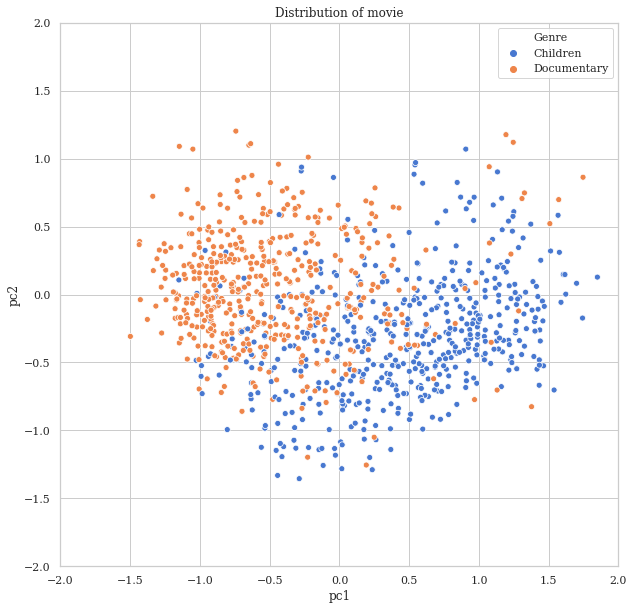

In [46]:
sns.scatterplot(x='pc1', y='pc2', data=plt_df, hue='Genre')
plt.title('Distribution of movie')
plt.xlim(-2,2)
plt.ylim(-2,2)

<Figure size 864x864 with 0 Axes>

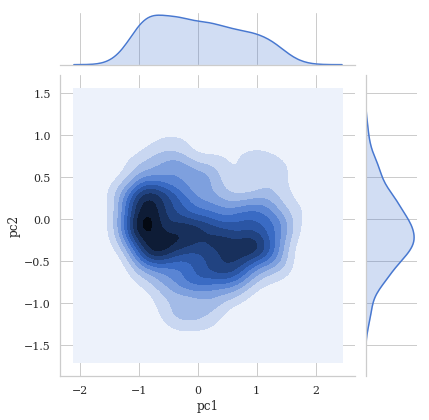

In [52]:
plt.figure(figsize=(12,12))
sns.jointplot(x='pc1', y='pc2', data=plt_df, kind='kde')

## Plot top 10 rated movies

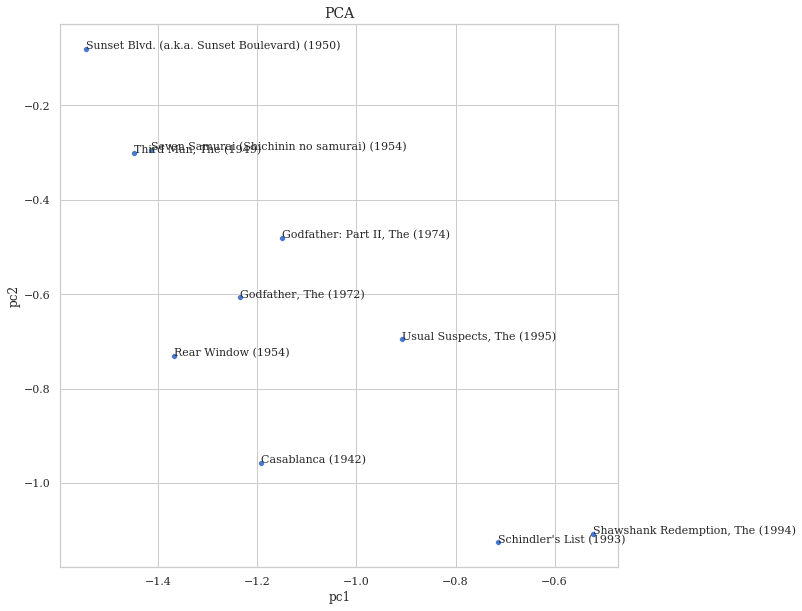

In [53]:
# get top 10 rated movies out of top 1000 most rated
top_10 = df.sort_values('n_ratings').tail(1000).sort_values('mean_rating', ascending=False).head(10)
sns.scatterplot(x='pc1', y='pc2', data=top_10)
plt.title('PCA', fontsize=14)
for idx, row in top_10.iterrows():
    plt.text(row.pc1, row.pc2, row.title, fontsize=11)
plt.show()
    
# sns.scatterplot(x='mds1', y='mds2', data=top_10)
# plt.title('MDS', fontsize=14)
# for idx, row in top_10.iterrows():
#     plt.text(row.mds1, row.mds2, row.title, fontsize=11)
# plt.show()

# sns.scatterplot(x='tsne1', y='tsne2', data=top_10)
# plt.title('t-SNE', fontsize=14)
# for idx, row in top_10.iterrows():
#     plt.text(row.tsne1, row.tsne2, row.title, fontsize=11)
# plt.show()

## Plot 10 worst rated movies

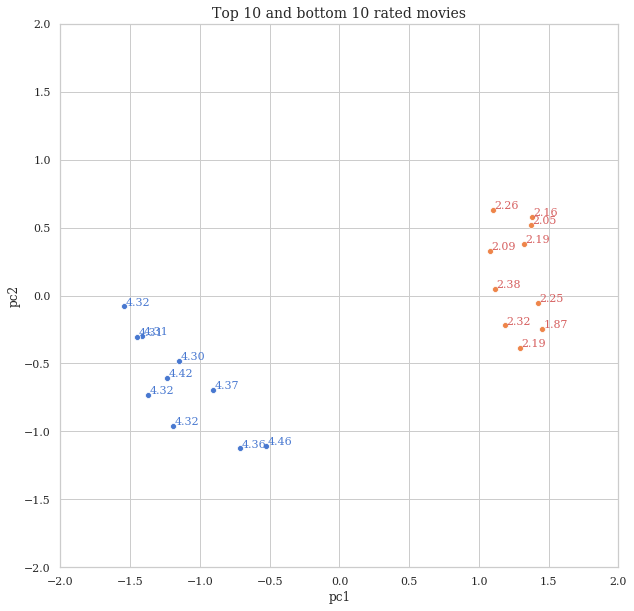

In [63]:
# get 10 worst rated movies
bot_10 = df.sort_values('n_ratings').tail(1000).sort_values('mean_rating').head(10)

# plot top and bottom 10
sns.scatterplot(x='pc1', y='pc2', data=top_10)
sns.scatterplot(x='pc1', y='pc2', data=bot_10)

# add mean rating labels
for idx, row in top_10.iterrows():
    plt.text(row.pc1+.01, row.pc2+.01, '{0:.2f}'.format(row.mean_rating), color='b', fontsize=11)
for idx, row in bot_10.iterrows():
    plt.text(row.pc1+.01, row.pc2+.01, '{0:.2f}'.format(row.mean_rating), color='r', fontsize=11)

plt.title('Top 10 and bottom 10 rated movies', fontsize=14)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.show()

In [109]:
' '.join(str.split('Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)')[:-1]) + ' (4.32)'

'Sunset Blvd. (a.k.a. Sunset Boulevard) (4.32)'

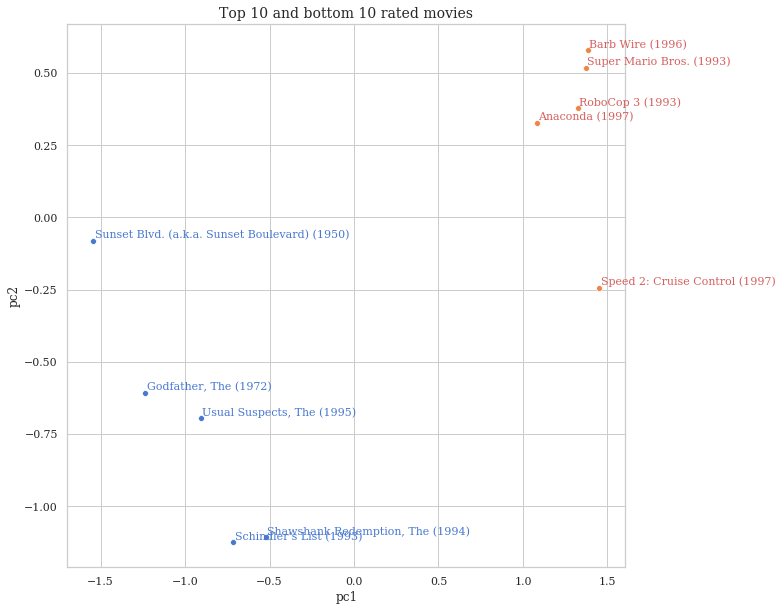

In [110]:
# plot top and bottom 5
sns.scatterplot(x='pc1', y='pc2', data=top_10.head())
sns.scatterplot(x='pc1', y='pc2', data=bot_10.head())

# add mean rating labels
for idx, row in top_10.head().iterrows():
    plt.text(row.pc1+.01, row.pc2+.01, row.title, color='b', fontsize=11)
for idx, row in bot_10.head().iterrows():
    plt.text(row.pc1+.01, row.pc2+.01, row.title, color='r', fontsize=11)

plt.title('Top 10 and bottom 10 rated movies', fontsize=14)
# plt.xlim(-2, 2)
# plt.ylim(-2, 2)
plt.show()

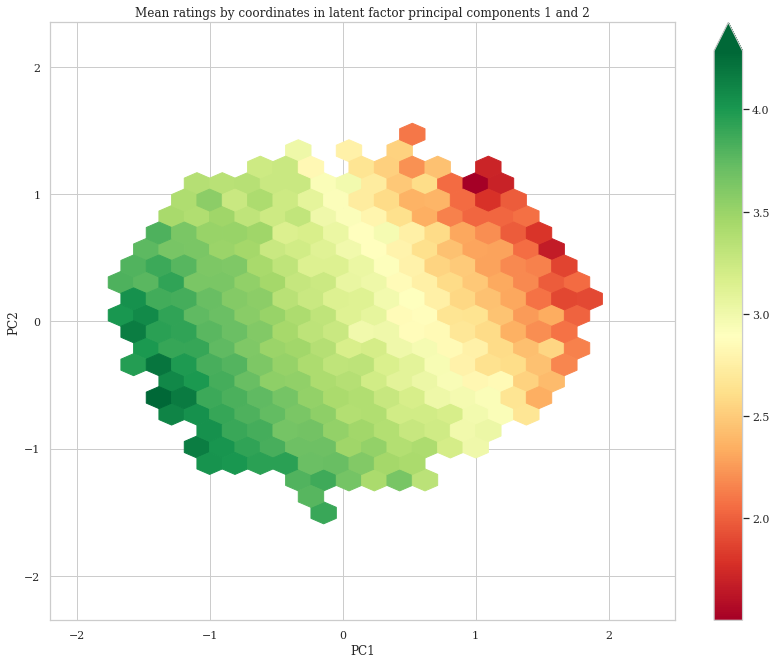

In [158]:
plt.figure(figsize=(14,11))
plt.hexbin(x=df.pc1, y=df.pc2, C=df.mean_rating,
           gridsize=22, cmap='RdYlGn', mincnt=2)
plt.xlim(-2.2, 2.5)
plt.ylim(-2.35, 2.35)
plt.colorbar(extend='max')
plt.title('Mean ratings by coordinates in latent factor principal components 1 and 2')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [116]:
train = pd.read_csv(path+'train_predictions.csv')
train['test'] = 0
test = pd.read_csv(path+'holdout_predictions.csv')
test['test'] = 1
preds = pd.concat((train, test), ignore_index=True)[['movieId', 'prediction', 'test']]
preds.head()

,movieId,prediction,test
0,3827,0,0
1,5666,0,0
2,1877,1,0
3,10407,1,0
4,5046,0,0


In [118]:
df = pd.merge(df, preds, on='movieId')
df.head()

,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,n_ratings,mean_rating,pc1,pc2,mds1,mds2,tsne1,tsne2,prediction,test
0,0,Boomerang (1992),0,0,0,0,1,0,0,0,...,2412,2.861318,0.733743,-0.413727,0.733743,-0.413726,0.733743,-0.413728,0,0
1,1,"Net, The (1995)",1,0,0,0,0,1,0,0,...,14975,3.125209,1.060578,-0.808901,1.060578,-0.808902,1.060578,-0.808900,0,0
2,2,Dumb & Dumber (1994),0,0,0,0,1,0,0,0,...,17851,2.936950,0.368845,0.118455,0.368845,0.118454,0.368845,0.118455,0,0
3,3,Outbreak (1995),1,0,0,0,0,0,0,1,...,16075,3.418414,0.752705,-0.836050,0.752705,-0.836050,0.752705,-0.836049,0,1
4,4,Stargate (1994),1,1,0,0,0,0,0,0,...,18925,3.349353,0.550180,-0.561947,0.550180,-0.561947,0.550180,-0.561946,0,0


In [123]:
df['correct'] = (df['Drama'] == df['prediction']).astype('int')

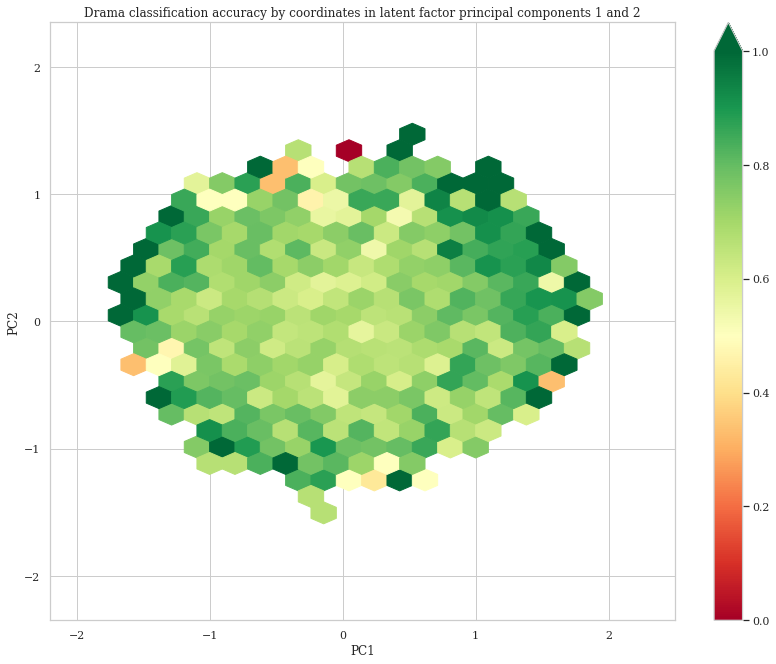

In [163]:
plt.figure(figsize=(14,11))
plt.hexbin(x=df.pc1, y=df.pc2, C=df.correct,
           gridsize=22, cmap='RdYlGn', mincnt=2)
plt.xlim(-2.2, 2.5)
plt.ylim(-2.35, 2.35)
plt.colorbar(extend='max')
plt.title('Drama classification accuracy by coordinates in latent factor principal components 1 and 2')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

## Plot some popular franchises

In [45]:
lotr = df[df.title.str.contains('Lord of the Rings') & ~df.title.str.contains('1978')]
hp = df[df.title.str.contains('Harry Potter')]
sw = df[df.title.str.contains('Star Wars')]
gf = df[df.title.str.contains('Godfather, The') | df.title.str.contains('Godfather: Part II')]

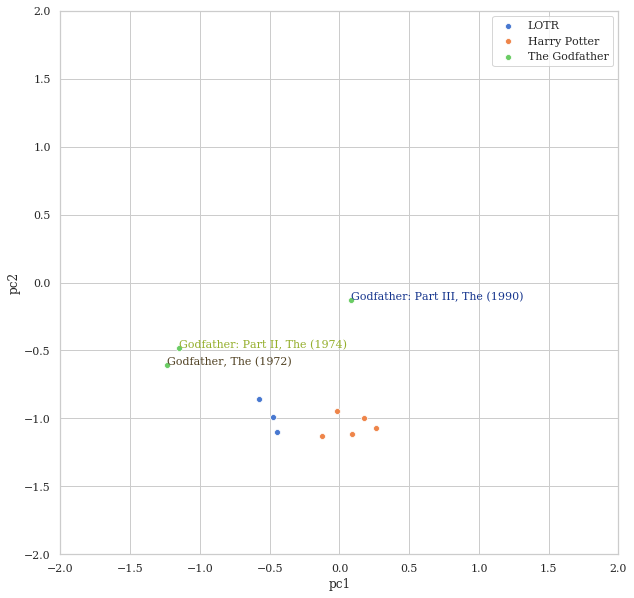

In [46]:
sns.scatterplot(x='pc1', y='pc2', data=lotr, label='LOTR')
sns.scatterplot(x='pc1', y='pc2', data=hp, label='Harry Potter')
# sns.scatterplot(x='pc1', y='pc2', data=sw, label='Star Wars')
sns.scatterplot(x='pc1', y='pc2', data=gf, label='The Godfather')
for idx, row in gf.iterrows():
    plt.text(row.pc1, row.pc2, row.title, color=np.random.rand(3)*0.7, fontsize=11)
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.legend()

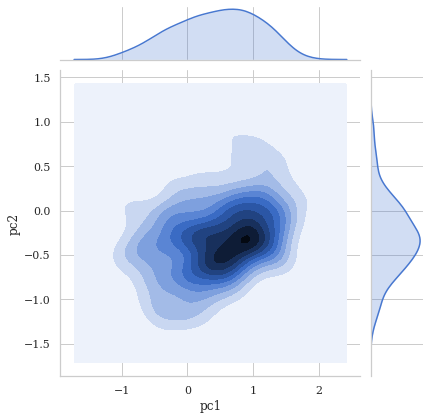

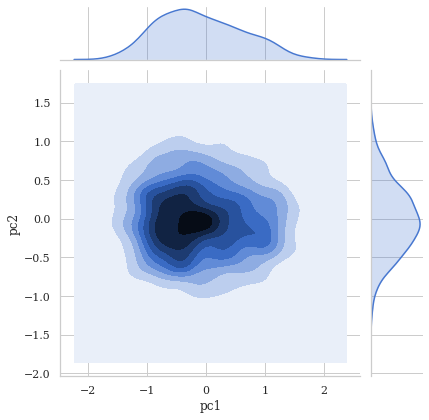

In [50]:
sns.jointplot(x='pc1', y='pc2', data=df[df['Children']==1], kind='kde', label='Children')
sns.jointplot(x='pc1', y='pc2', data=df[df['Crime']==1], kind='kde', label='Crime')